In [1]:
import scanpy
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from anndata import AnnData

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set_context('talk')

In [3]:
DIRECTORY = "/data/norman/southark/tfs_standardized"

In [4]:
guide_library = pd.read_csv(
    f'{DIRECTORY}/20240410_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef_wGuide_labels.csv',
    index_col=0
)

In [5]:
active_pops = dict()

In [6]:
# load log normalized guide-expression profiles of single cells
active_pops['fibro'] = scanpy.read_h5ad(f"{DIRECTORY}/250122_fibro_CRISPRa_final_population_singlets_normalized_log1p_active.h5ad")
active_pops['rpe1'] = scanpy.read_h5ad(f"{DIRECTORY}/250122_RPE1_CRISPRa_final_population_singlets_normalized_log1p_active.h5ad")

### Preprocessing

In [7]:
def average_of_top_per_column(array, pct=0.01):
    
    sorted_array = np.sort(array, axis=0)[::-1]
    top_values = sorted_array[:int(array.shape[0]*pct), :]
    average_top = np.mean(top_values, axis=0)

    return average_top

In [8]:
# expressed genes
average_top_fibro = average_of_top_per_column(active_pops['fibro'].X.toarray())
average_top_rpe1 = average_of_top_per_column(active_pops['rpe1'].X.toarray())
expressed_fibro = active_pops['fibro'].var[average_top_fibro > 0.5].gene_name.values
expressed_rpe1 = active_pops['rpe1'].var[average_top_rpe1 > 0.5].gene_name.values

In [9]:
# highly expressed genes
expr_high_fibro = active_pops['fibro'].var[np.quantile(active_pops['fibro'].X.toarray(), 0.8, axis=0) > 0.5].gene_name.values
expr_high_rpe1 = active_pops['rpe1'].var[np.quantile(active_pops['rpe1'].X.toarray(), 0.8, axis=0) > 0.5].gene_name.values

In [10]:
cutoff = 5 # minimum 5 cells per guide

In [11]:
keep_pert_fibro = active_pops['fibro'].obs.guide_identity.value_counts().to_frame("n_cells").query("n_cells >= @cutoff").index.values
keep_pert_rpe1 = active_pops['rpe1'].obs.guide_identity.value_counts().to_frame("n_cells").query("n_cells >= @cutoff").index.values

In [12]:
filtered_active_pops = dict()

In [13]:
filtered_active_pops['fibro'] = active_pops['fibro'][active_pops['fibro'].obs.query("guide_identity.isin(@keep_pert_fibro)").index]
filtered_active_pops['rpe1'] = active_pops['rpe1'][active_pops['rpe1'].obs.query("guide_identity.isin(@keep_pert_rpe1)").index]

In [14]:
fibro_guides = np.array(filtered_active_pops['fibro'].obs.query("not control").guide_identity.unique())
rpe1_guides = np.array(filtered_active_pops['rpe1'].obs.query("not control").guide_identity.unique())

In [15]:
with open('top_common_perturbations.npy', 'rb') as f:
    top_common_pert = np.load(f, allow_pickle=True)

In [16]:
mean_pops = dict()

In [19]:
# calculate mean profile

def aggregate_anndata(adata, groupby_column, numeric_columns, categorical_columns, agg_func='mean'):
    
    aggregated_adata = scanpy.get.aggregate(adata, by=groupby_column, func=agg_func)

    aggregated_numeric = (
        adata.obs[[groupby_column] + numeric_columns]
        .groupby(groupby_column, observed=False)  # Silence pandas warning
        .agg(agg_func)
    )

    aggregated_categorical = (
        adata.obs[[groupby_column] + categorical_columns]
        .groupby(groupby_column, observed=False)  # Silence pandas warning
        .first()  # Take the first occurrence for categorical columns
    )

    aggregated_obs = pd.concat([aggregated_numeric, aggregated_categorical], axis=1)

    aggregated_obs.index = aggregated_obs.index.astype(str)

    aggregated_adata.obs = aggregated_obs

    aggregated_adata.X = aggregated_adata.layers['mean']

    return aggregated_adata

In [20]:
groupby_column = 'guide_identity'
numeric_columns = ['UMI_count', 'guide_umi_count', 'mt_frac', 'pairwise_coef',
                   'pairwise_UMI_count', 'pairwise_singlet_equivalent_UMI_count']
categorical_columns = ['guide_target', 'protospacer', 'control']

mean_pops["fibro"] = aggregate_anndata(filtered_active_pops['fibro'], 'guide_identity', numeric_columns, categorical_columns, agg_func='mean')
mean_pops["rpe1"] = aggregate_anndata(filtered_active_pops['rpe1'], 'guide_identity', numeric_columns, categorical_columns, agg_func='mean')

In [21]:
mean_pops["fibro"].var = mean_pops["fibro"].var.reset_index().set_index("gene_name")
mean_pops["rpe1"].var = mean_pops["rpe1"].var.reset_index().set_index("gene_name")

In [22]:
map_guides = pd.read_csv(f"{DIRECTORY}/250122_guide_target_gene_mapping.csv")

In [23]:
mean_pops["fibro"].obs = mean_pops["fibro"].obs.merge(
    map_guides, left_index=True, right_on="guide_identity", how="left"
).set_index("guide_identity")

mean_pops["rpe1"].obs = mean_pops["rpe1"].obs.merge(
    map_guides, left_index=True, right_on="guide_identity", how="left"
).set_index("guide_identity")

In [24]:
# mask expression of target gene by median

def mask_target_gene_expression(
    adata: AnnData,
    target_gene_col: str = "target_gene",
    inplace: bool = False,
    verbose: bool = True
) -> AnnData:
    
    if not inplace:
        adata = adata.copy()
    
    if target_gene_col not in adata.obs:
        raise ValueError(f"Column '{target_gene_col}' not found in adata.obs")
    
    target_genes = adata.obs[target_gene_col].values
    unique_targets = pd.unique(target_genes)
    gene_names = adata.var_names
    
    if not isinstance(adata.X, np.ndarray):
        if verbose:
            print("Converting .X to dense array for modification")
        X = adata.X.toarray()
    else:
        X = adata.X.copy()
    
    median_cache = {}
    
    for gene in unique_targets:
        if gene not in gene_names:
            if verbose:
                print(f"Warning: Target gene '{gene}' not found in var_names, skipping")
            continue
            
        gene_idx = gene_names.get_loc(gene)
        target_mask = (target_genes == gene)
        non_target_mask = ~target_mask
        
        if not non_target_mask.any():
            if verbose:
                print(f"Warning: No non-target perturbations for '{gene}', skipping")
            continue
            
        if gene not in median_cache:
            median_cache[gene] = np.median(X[non_target_mask, gene_idx])
            
        X[target_mask, gene_idx] = median_cache[gene]
    
    adata.X = X
    
    return adata

In [25]:
mean_pops["fibro"] = mask_target_gene_expression(mean_pops["fibro"])
mean_pops["rpe1"] = mask_target_gene_expression(mean_pops["rpe1"])

### GO terms scoring

In [26]:
import gseapy as gp

In [27]:
gmt_files = dict()
gene_sets = dict()

In [28]:
gmt_dir = "/data/norman/angel/gmt"

In [29]:
gmt_files["GO"] = f"{gmt_dir}/c5.go.v2024.1.Hs.symbols.gmt" # Gene Ontology gene set
gene_sets["GO"] = gp.parser.read_gmt(gmt_files["GO"])

gene_sets["GOBP"] = {k:v for k, v in gene_sets["GO"].items() if k.startswith("GOBP")}
gene_sets["GOMF"] = {k:v for k, v in gene_sets["GO"].items() if k.startswith("GOMF")}
gene_sets["GOCC"] = {k:v for k, v in gene_sets["GO"].items() if k.startswith("GOCC")}

In [30]:
from score_genes_perturbed import score_genes_relative_to_control

In [ ]:
gs = "GOBP"
for name, gene_list in gene_sets[gs].items():
    try:
        score_genes_relative_to_control(mean_pops['fibro'], cell_pool=mean_pops['fibro'].obs.control,
                                        gene_list=gene_list, ctrl_size=100, score_name=name)
    except:
        print(f"No valid genes were passed for scoring. {name=}.")

mean_pops['fibro'].obsm[gs] = mean_pops['fibro'].obs.iloc[:, 11:].copy().dropna(axis=1)
mean_pops['fibro'].obs = mean_pops['fibro'].obs.iloc[:, :11].copy()

In [ ]:
for name, gene_list in gene_sets[gs].items():
    try:
        score_genes_relative_to_control(mean_pops['rpe1'], cell_pool=mean_pops['rpe1'].obs.control,
                                        gene_list=gene_list, ctrl_size=100, score_name=name)
    except:
        print(f"No valid genes were passed for scoring. {name=}.")

mean_pops['rpe1'].obsm[gs] = mean_pops['rpe1'].obs.iloc[:, 11:].copy().dropna(axis=1)
mean_pops['rpe1'].obs = mean_pops['rpe1'].obs.iloc[:, :11].copy()

In [33]:
mean_pops['fibro'].obsm[f"{gs}_znorm"] = ((mean_pops['fibro'].obsm[gs] \
                                          - mean_pops['fibro'][mean_pops['fibro'].obs.query("control").index].obsm[gs].mean()) \
/ mean_pops['fibro'][mean_pops['fibro'].obs.query("control").index].obsm[gs].std()).dropna(axis=1)

mean_pops['rpe1'].obsm[f"{gs}_znorm"] = ((mean_pops['rpe1'].obsm[gs] \
                                        - mean_pops['rpe1'][mean_pops['rpe1'].obs.query("control").index].obsm[gs].mean()) \
/ mean_pops['rpe1'][mean_pops['rpe1'].obs.query("control").index].obsm[gs].std()).dropna(axis=1)

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

def calculate_z_scores_and_p_values(control_df, test_df, fdr_correction=True, alpha=0.05):
    
    if not control_df.columns.equals(test_df.columns):
        raise ValueError("Control and test DataFrames must have the same columns (pathways).")

    means = control_df.mean(axis=0) 
    stds = control_df.std(axis=0, ddof=1)  # Sample standard deviation (Bessel's correction)

    z_scores = (test_df - means) / stds

    p_values = 2 * norm.sf(np.abs(z_scores))  # sf = survival function (1 - CDF)

    z_score_df = pd.DataFrame(
        z_scores,
        index=test_df.index,
        columns=test_df.columns
    )

    p_value_df = pd.DataFrame(
        p_values,
        index=test_df.index,
        columns=test_df.columns
    )

    fdr_p_value_df = None
    if fdr_correction:
        flat_p_values = p_value_df.values.flatten()
        fdr_corrected = multipletests(flat_p_values, alpha=alpha, method='fdr_bh')[1]
        fdr_p_value_df = pd.DataFrame(
            fdr_corrected.reshape(p_value_df.shape),
            index=test_df.index,
            columns=test_df.columns
        )

    return z_score_df, p_value_df, fdr_p_value_df

In [35]:
z_score_fibro, p_value_fibro, fdr_fibro = dict(), dict(), dict()
z_score_rpe1, p_value_rpe1, fdr_rpe1 = dict(), dict(), dict()

In [36]:
z_score_fibro[gs], p_value_fibro[gs], fdr_fibro[gs] = calculate_z_scores_and_p_values(
    mean_pops['fibro'].obsm[f"{gs}_znorm"].query("guide_identity.str.startswith('non')"),
    mean_pops['fibro'].obsm[f"{gs}_znorm"].query("~guide_identity.str.startswith('non')")
)

z_score_rpe1[gs], p_value_rpe1[gs], fdr_rpe1[gs] = calculate_z_scores_and_p_values(
    mean_pops['rpe1'].obsm[f"{gs}_znorm"].query("guide_identity.str.startswith('non')"),
    mean_pops['rpe1'].obsm[f"{gs}_znorm"].query("~guide_identity.str.startswith('non')")
)

In [37]:
meta_data = dict()

In [38]:
meta_data[gs] = pd.DataFrame({k: len(v) for k, v in gene_sets[gs].items()}.items())
meta_data[gs].columns = ["Term", "n_genes"]

meta_data[gs]["fraction_fibro"] = [len(mean_pops["fibro"].var.index.intersection(v)) / len(v) for k, v in gene_sets[gs].items()]
meta_data[gs]["fraction_rpe1"] = [len(mean_pops["rpe1"].var.index.intersection(v)) / len(v) for k, v in gene_sets[gs].items()]

meta_data[gs]["expressed_frac_fibro"] = [len(np.intersect1d(expressed_fibro, v)) / len(v) for k, v in gene_sets[gs].items()]
meta_data[gs]["expressed_frac_rpe1"] = [len(np.intersect1d(expressed_rpe1, v)) / len(v) for k, v in gene_sets[gs].items()]

In [39]:
select_terms = dict()

In [40]:
select_terms[gs] = meta_data[gs].query(
    "fraction_fibro > 0.5 and fraction_rpe1 > 0.5"
).query(
    "expressed_frac_fibro > 0.6 or expressed_frac_rpe1 > 0.6"
).query("15 < n_genes < 500").Term

In [41]:
dfs = {"GOBP":{}}

In [42]:
dfs[gs]['fibro'] = mean_pops['fibro'].obsm[f"{gs}_znorm"].query("~guide_identity.str.startswith('non')")
dfs[gs]['rpe1'] = mean_pops['rpe1'].obsm[f"{gs}_znorm"].query("~guide_identity.str.startswith('non')")

In [43]:
masked_dfs = {"GOBP":{}}

In [44]:
masked_dfs[gs]['fibro'] = mean_pops['fibro'].obsm[f"{gs}_znorm"].query(
    "~guide_identity.str.startswith('non')").where(fdr_fibro[gs] < 0.05)
masked_dfs[gs]['rpe1'] = mean_pops['rpe1'].obsm[f"{gs}_znorm"].query(
    "~guide_identity.str.startswith('non')").where(fdr_rpe1[gs] < 0.05)

In [45]:
common_pert = fdr_fibro["GOBP"].index.intersection(fdr_rpe1["GOBP"].index)

In [46]:
top_common_pert = np.intersect1d(top_common_pert, common_pert)

In [47]:
common_dfs = {"GOBP":{}}

In [48]:
common_dfs[gs]['fibro'] = dfs[gs]['fibro'].loc[common_pert, select_terms[gs]]
common_dfs[gs]['rpe1'] = dfs[gs]['rpe1'].loc[common_pert, select_terms[gs]]

In [49]:
common_masked_dfs = {"GOBP":{}, "Hallmark":{}, "CellMarker":{}, "progeny":{}}

In [50]:
common_masked_dfs[gs]['fibro'] = masked_dfs[gs]['fibro'].loc[common_pert, select_terms[gs]]
common_masked_dfs[gs]['rpe1'] = masked_dfs[gs]['rpe1'].loc[common_pert, select_terms[gs]]

### Global clustering

In [51]:
import hdbscan

In [52]:
score = "GOBP"

fibro_df = common_masked_dfs[score]['fibro'].fillna(0).T
rpe1_df = common_masked_dfs[score]['rpe1'].fillna(0).T

filtered_fibro_df = fibro_df.copy()
filtered_rpe1_df = rpe1_df.copy()

In [ ]:
row_clusterer_fibro = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, max_cluster_size=50, metric="correlation")
row_labels_fibro = row_clusterer_fibro.fit_predict(fibro_df)

filtered_fibro_df['cluster'] = row_labels_fibro
selected_fibro_df = filtered_fibro_df[filtered_fibro_df['cluster'] != -1]

In [ ]:
row_clusterer_rpe1 = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, max_cluster_size=50, metric="correlation")
row_labels_rpe1 = row_clusterer_rpe1.fit_predict(rpe1_df)

filtered_rpe1_df['cluster'] = row_labels_rpe1
selected_rpe1_df = filtered_rpe1_df[filtered_rpe1_df['cluster'] != -1]

In [55]:
selected_both = selected_fibro_df.index.union(selected_rpe1_df.index)

In [56]:
from scipy.cluster.hierarchy import linkage, dendrogram, optimal_leaf_ordering
from scipy.spatial.distance import squareform, pdist

In [57]:
combined_df1 = pd.concat([fibro_df.loc[selected_both, common_pert].add_prefix("fibro_"),
                          rpe1_df.loc[selected_both, common_pert].add_prefix("rpe1_")], axis=1)

correlation_distances_row = pdist(combined_df1, metric='correlation')
Z_row = linkage(correlation_distances_row, method='average')
optimal_Z_row = optimal_leaf_ordering(Z_row, correlation_distances_row)

In [58]:
combined_df2 = pd.concat([fibro_df.loc[selected_both, common_pert].T.add_prefix("fibro_"), 
                          rpe1_df.loc[selected_both, common_pert].T.add_prefix("rpe1_")], axis=1)

correlation_distances_col = pdist(combined_df2, metric='correlation')
Z_col = linkage(correlation_distances_col, method='average')
optimal_Z_col = optimal_leaf_ordering(Z_col, correlation_distances_col)

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.cluster.hierarchy as sch
import numpy as np
from scipy.stats import pearsonr

def plot_shared_clustermaps_with_correlations(df1, df2, row_linkage, col_linkage, 
                                            vmin=-3, vmax=3, cmap="RdBu_r", figsize=(60, 50),
                                            titles=None, row_correlations=None, col_correlations=None):
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Create GridSpec with space for correlation panels and labels
    gs = GridSpec(3, 4, figure=fig, 
                  height_ratios=[0.1, 0.8, 0.02],
                 width_ratios=[0.1, 0.4, 0.4, 0.016],
                 hspace=0.02, wspace=0.02)
    
    # Create axes
    ax_dendro_row = fig.add_subplot(gs[1, 0])
    ax_heatmap1 = fig.add_subplot(gs[1, 1])
    ax_heatmap2 = fig.add_subplot(gs[1, 2])
    ax_row_corr = fig.add_subplot(gs[1, 3])
    ax_dendro_col1 = fig.add_subplot(gs[0, 1])
    ax_dendro_col2 = fig.add_subplot(gs[0, 2])
    ax_col_corr1 = fig.add_subplot(gs[2, 1])
    ax_col_corr2 = fig.add_subplot(gs[2, 2])
    
    # Create colorbar axes
    cbar_ax = fig.add_axes([0.148, 0.798, 0.015, 0.07])
    corr_cbar_ax = fig.add_axes([0.18, 0.798, 0.015, 0.07])
    
    # Remove spines from dendrograms
    for ax in [ax_dendro_row, ax_dendro_col1, ax_dendro_col2]:
        for spine in ax.spines.values():
            spine.set_visible(False)
    
    # Get dendrograms
    row_dendro = sch.dendrogram(row_linkage, ax=ax_dendro_row, orientation='left')
    col_dendro1 = sch.dendrogram(col_linkage, ax=ax_dendro_col1)
    col_dendro2 = sch.dendrogram(col_linkage, ax=ax_dendro_col2)
    
    # Get reordering indices
    row_idx = row_dendro['leaves']
    col_idx = col_dendro1['leaves']
    
    # Reorder data
    df1_reordered = df1.iloc[row_idx, col_idx]
    df2_reordered = df2.iloc[row_idx, col_idx]
            
    def nanwise_corr(x, y):
        mask = ~(np.isnan(x) | np.isnan(y))
        if np.sum(mask) > 1:
            return np.corrcoef(x[mask], y[mask])[0,1]
        return np.nan
    
    if row_correlations is None or col_correlations is None:
        def nanwise_corr(x, y):
            mask = ~(np.isnan(x) | np.isnan(y))
            if np.sum(mask) > 1:
                return np.corrcoef(x[mask], y[mask])[0,1]
            return np.nan

        # Row-wise correlations
        row_correlations = [nanwise_corr(df1_reordered.iloc[i], df2_reordered.iloc[i]) 
                           for i in range(len(df1_reordered))]

        # Column-wise correlations 
        col_correlations = [nanwise_corr(df1_reordered.iloc[:, i], df2_reordered.iloc[:, i]) 
                           for i in range(df1_reordered.shape[1])]
    
    sns.heatmap(df1_reordered, ax=ax_heatmap1, cmap=cmap, vmin=vmin, vmax=vmax,
                xticklabels=False, yticklabels=False, center=0, cbar=False)
    
    im = sns.heatmap(df2_reordered, ax=ax_heatmap2, cmap=cmap, vmin=vmin, vmax=vmax,
                     xticklabels=False, yticklabels=False, center=0, cbar=False)
    
    
    # Plot correlation heatmaps
    row_corr_data = np.array(row_correlations).reshape(-1, 1)
    col_corr_data = np.array(col_correlations).reshape(1, -1)
    
    # Create correlation colormap
    corr_cmap = sns.color_palette("PuOr", as_cmap=True)
    corr_cmap.set_bad(color='grey')
    
    # Plot row correlations with yticklabels on the right
    sns.heatmap(row_corr_data, ax=ax_row_corr, cmap=corr_cmap,
                vmin=-1, vmax=1, center=0,
                xticklabels=False, yticklabels=df1_reordered.index,
                cbar=True, cbar_ax=corr_cbar_ax)
    
    ax_row_corr.tick_params(axis='y', labelsize=8)
    
    # Plot column correlations
    sns.heatmap(col_corr_data, ax=ax_col_corr1, cmap=corr_cmap,
                vmin=-1, vmax=1, center=0,
                xticklabels=True, yticklabels=False,
                cbar=False)
    
    sns.heatmap(col_corr_data, ax=ax_col_corr2, cmap=corr_cmap,
                vmin=-1, vmax=1, center=0,
                xticklabels=True, yticklabels=False,
                cbar=False)
    
    # Create main colorbar
    cbar = plt.colorbar(im.collections[0], cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_title('GO scores', fontsize=20)
    
    # Format correlation colorbar
    corr_cbar_ax.set_title('Correlation', fontsize=20)
    corr_cbar_ax.tick_params(labelsize=18)
    
    # Add titles
    if titles:
        ax_dendro_col1.set_title(titles[0], fontsize=28)
        ax_dendro_col2.set_title(titles[1], fontsize=28)
    
    # Set column labels for correlation heatmaps
    ax_col_corr1.set_xticklabels(df1_reordered.columns, rotation=90, ha='center', fontsize=8)
    ax_col_corr2.set_xticklabels(df1_reordered.columns, rotation=90, ha='center', fontsize=8)
    
    # Format row correlation y-axis labels
    ax_row_corr.yaxis.set_label_position('right')
    ax_row_corr.yaxis.tick_right()
    plt.setp(ax_row_corr.get_yticklabels(), rotation=0, ha='left')
    
    # Add frames around heatmaps
    for ax in [ax_heatmap1, ax_heatmap2, ax_row_corr, ax_col_corr1, ax_col_corr2]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
            spine.set_color('black')
            
    for spine in corr_cbar_ax.spines.values():
        spine.set_visible(True)
    
    # Remove dendrogram ticks
    ax_dendro_row.set_xticks([])
    ax_dendro_row.set_yticks([])
    ax_dendro_col1.set_xticks([])
    ax_dendro_col1.set_yticks([])
    ax_dendro_col2.set_xticks([])
    ax_dendro_col2.set_yticks([])
    
    # Format correlation panels titles
    ax_row_corr.set_title('r', fontsize=28)
    
    ax_heatmap1.set_xlabel('')
    ax_heatmap2.set_xlabel('')
    
    return fig, row_correlations, col_correlations

In [60]:
fig, row_corrs, col_corrs = plot_shared_clustermaps_with_correlations(
    common_dfs[score]['fibro'].T.loc[selected_both, common_pert],
    common_dfs[score]['rpe1'].T.loc[selected_both, common_pert],
    optimal_Z_row, optimal_Z_col, vmax=8, vmin=-8, figsize=(105, 80), titles=["Hs27", "RPE-1"],
)
#fig.savefig(f'20250213_GOBP_cocluster.pdf', bbox_inches='tight')

### Conserved analyses

In [ ]:
fibro_df = common_masked_dfs[score]['fibro'].fillna(0).T
rpe1_df = common_masked_dfs[score]['rpe1'].fillna(0).T

filtered_fibro_df = fibro_df.copy()
filtered_rpe1_df = rpe1_df.copy()

# less strict clustering (filtering)
row_clusterer_fibro = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, max_cluster_size=50, metric="correlation")
row_labels_fibro = row_clusterer_fibro.fit_predict(fibro_df)

filtered_fibro_df['cluster'] = row_labels_fibro
selected_fibro_df = filtered_fibro_df[filtered_fibro_df['cluster'] != -1]

row_clusterer_rpe1 = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, max_cluster_size=50, metric="correlation")
row_labels_rpe1 = row_clusterer_rpe1.fit_predict(rpe1_df)

filtered_rpe1_df['cluster'] = row_labels_rpe1
selected_rpe1_df = filtered_rpe1_df[filtered_rpe1_df['cluster'] != -1]

selected_both = selected_fibro_df.index.union(selected_rpe1_df.index)

In [62]:
filtered_fibro_df = common_dfs[score]['fibro'].T.loc[selected_both, common_pert]
filtered_rpe1_df = common_dfs[score]['rpe1'].T.loc[selected_both, common_pert]

In [64]:
# select conserved GO terms
GO_thres = filtered_fibro_df.T.corrwith(filtered_rpe1_df.T).quantile(0.95)
conserved_GO = filtered_fibro_df.T.corrwith(filtered_rpe1_df.T).to_frame("GO_corr").query("GO_corr > @GO_thres").index

Text(0.5, 0, 'correlation of GO terms')

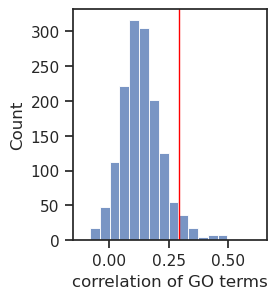

In [65]:
sns.set(style="ticks")
plt.subplots(figsize=(2.5, 3))
sns.histplot(filtered_fibro_df.T.corrwith(filtered_rpe1_df.T).sort_values(), bins=20)
plt.xlim(-0.15, 0.66)
plt.axvline(GO_thres, color="red", linewidth=1)
plt.xlabel("correlation of GO terms")
#plt.savefig('20250212_GO_term_correlations_hist.pdf', bbox_inches='tight')

In [ ]:
#filtered_fibro_df.T.corrwith(filtered_rpe1_df.T).to_frame("corr").to_csv("GO_correlations.csv")

In [66]:
# select conserved perturbations
guide_thres = filtered_fibro_df.loc[conserved_GO].corrwith(filtered_rpe1_df.loc[conserved_GO]).quantile(0.85)
conserved_guides = filtered_fibro_df.loc[conserved_GO].corrwith(
    filtered_rpe1_df.loc[conserved_GO]).to_frame("guide_corr").query("guide_corr > @guide_thres")

In [67]:
combined_df1 = pd.concat([filtered_fibro_df.loc[conserved_GO, conserved_guides.index].add_prefix("fibro_"),
                          filtered_rpe1_df.loc[conserved_GO, conserved_guides.index].add_prefix("rpe1_")], axis=1)
correlation_distances_row = pdist(combined_df1, metric='correlation')
Z_row = linkage(correlation_distances_row, method='average')
optimal_Z_row = optimal_leaf_ordering(Z_row, correlation_distances_row)

In [68]:
combined_df2 = pd.concat([filtered_fibro_df.loc[conserved_GO, conserved_guides.index].T.add_prefix("fibro_"), 
                          filtered_rpe1_df.loc[conserved_GO, conserved_guides.index].T.add_prefix("rpe1_")], axis=1)
correlation_distances_col = pdist(combined_df2, metric='correlation')
Z_col = linkage(correlation_distances_col, method='average')
optimal_Z_col = optimal_leaf_ordering(Z_col, correlation_distances_col)

In [69]:
row_idx = sch.leaves_list(optimal_Z_row)
col_idx = sch.leaves_list(optimal_Z_col)

select1 = filtered_fibro_df.loc[conserved_GO, conserved_guides.index].iloc[row_idx, col_idx]
select2 = filtered_rpe1_df.loc[conserved_GO, conserved_guides.index].iloc[row_idx, col_idx]

In [70]:
guide_map = guide_library.guide_label.to_dict()

In [71]:
select1.columns = select1.columns.map(guide_map)
select2.columns = select2.columns.map(guide_map)

In [72]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(optimal_Z_row, 10, criterion='maxclust')

In [73]:
reordered_clusters = clusters[row_idx]

In [74]:
clusters = {i: select1[reordered_clusters == i].index.values for i in np.unique(reordered_clusters)}

In [75]:
cluster_names = ["Ribosome Biogenesis",
                 "Mitochondrial Energy Metabolism",
                 "Redox and Quinone Metabolism",
                 "Neutrophil Homeostasis",
                 "Antigen Processing and T Cell Activation",
                 "Hepatocyte Apoptosis",
                 "Signaling and Differentiation",
                 "EMT and Development",
                 "mTOR Signaling and Proteolysis",
                 "Protein Maturation and Activation"]

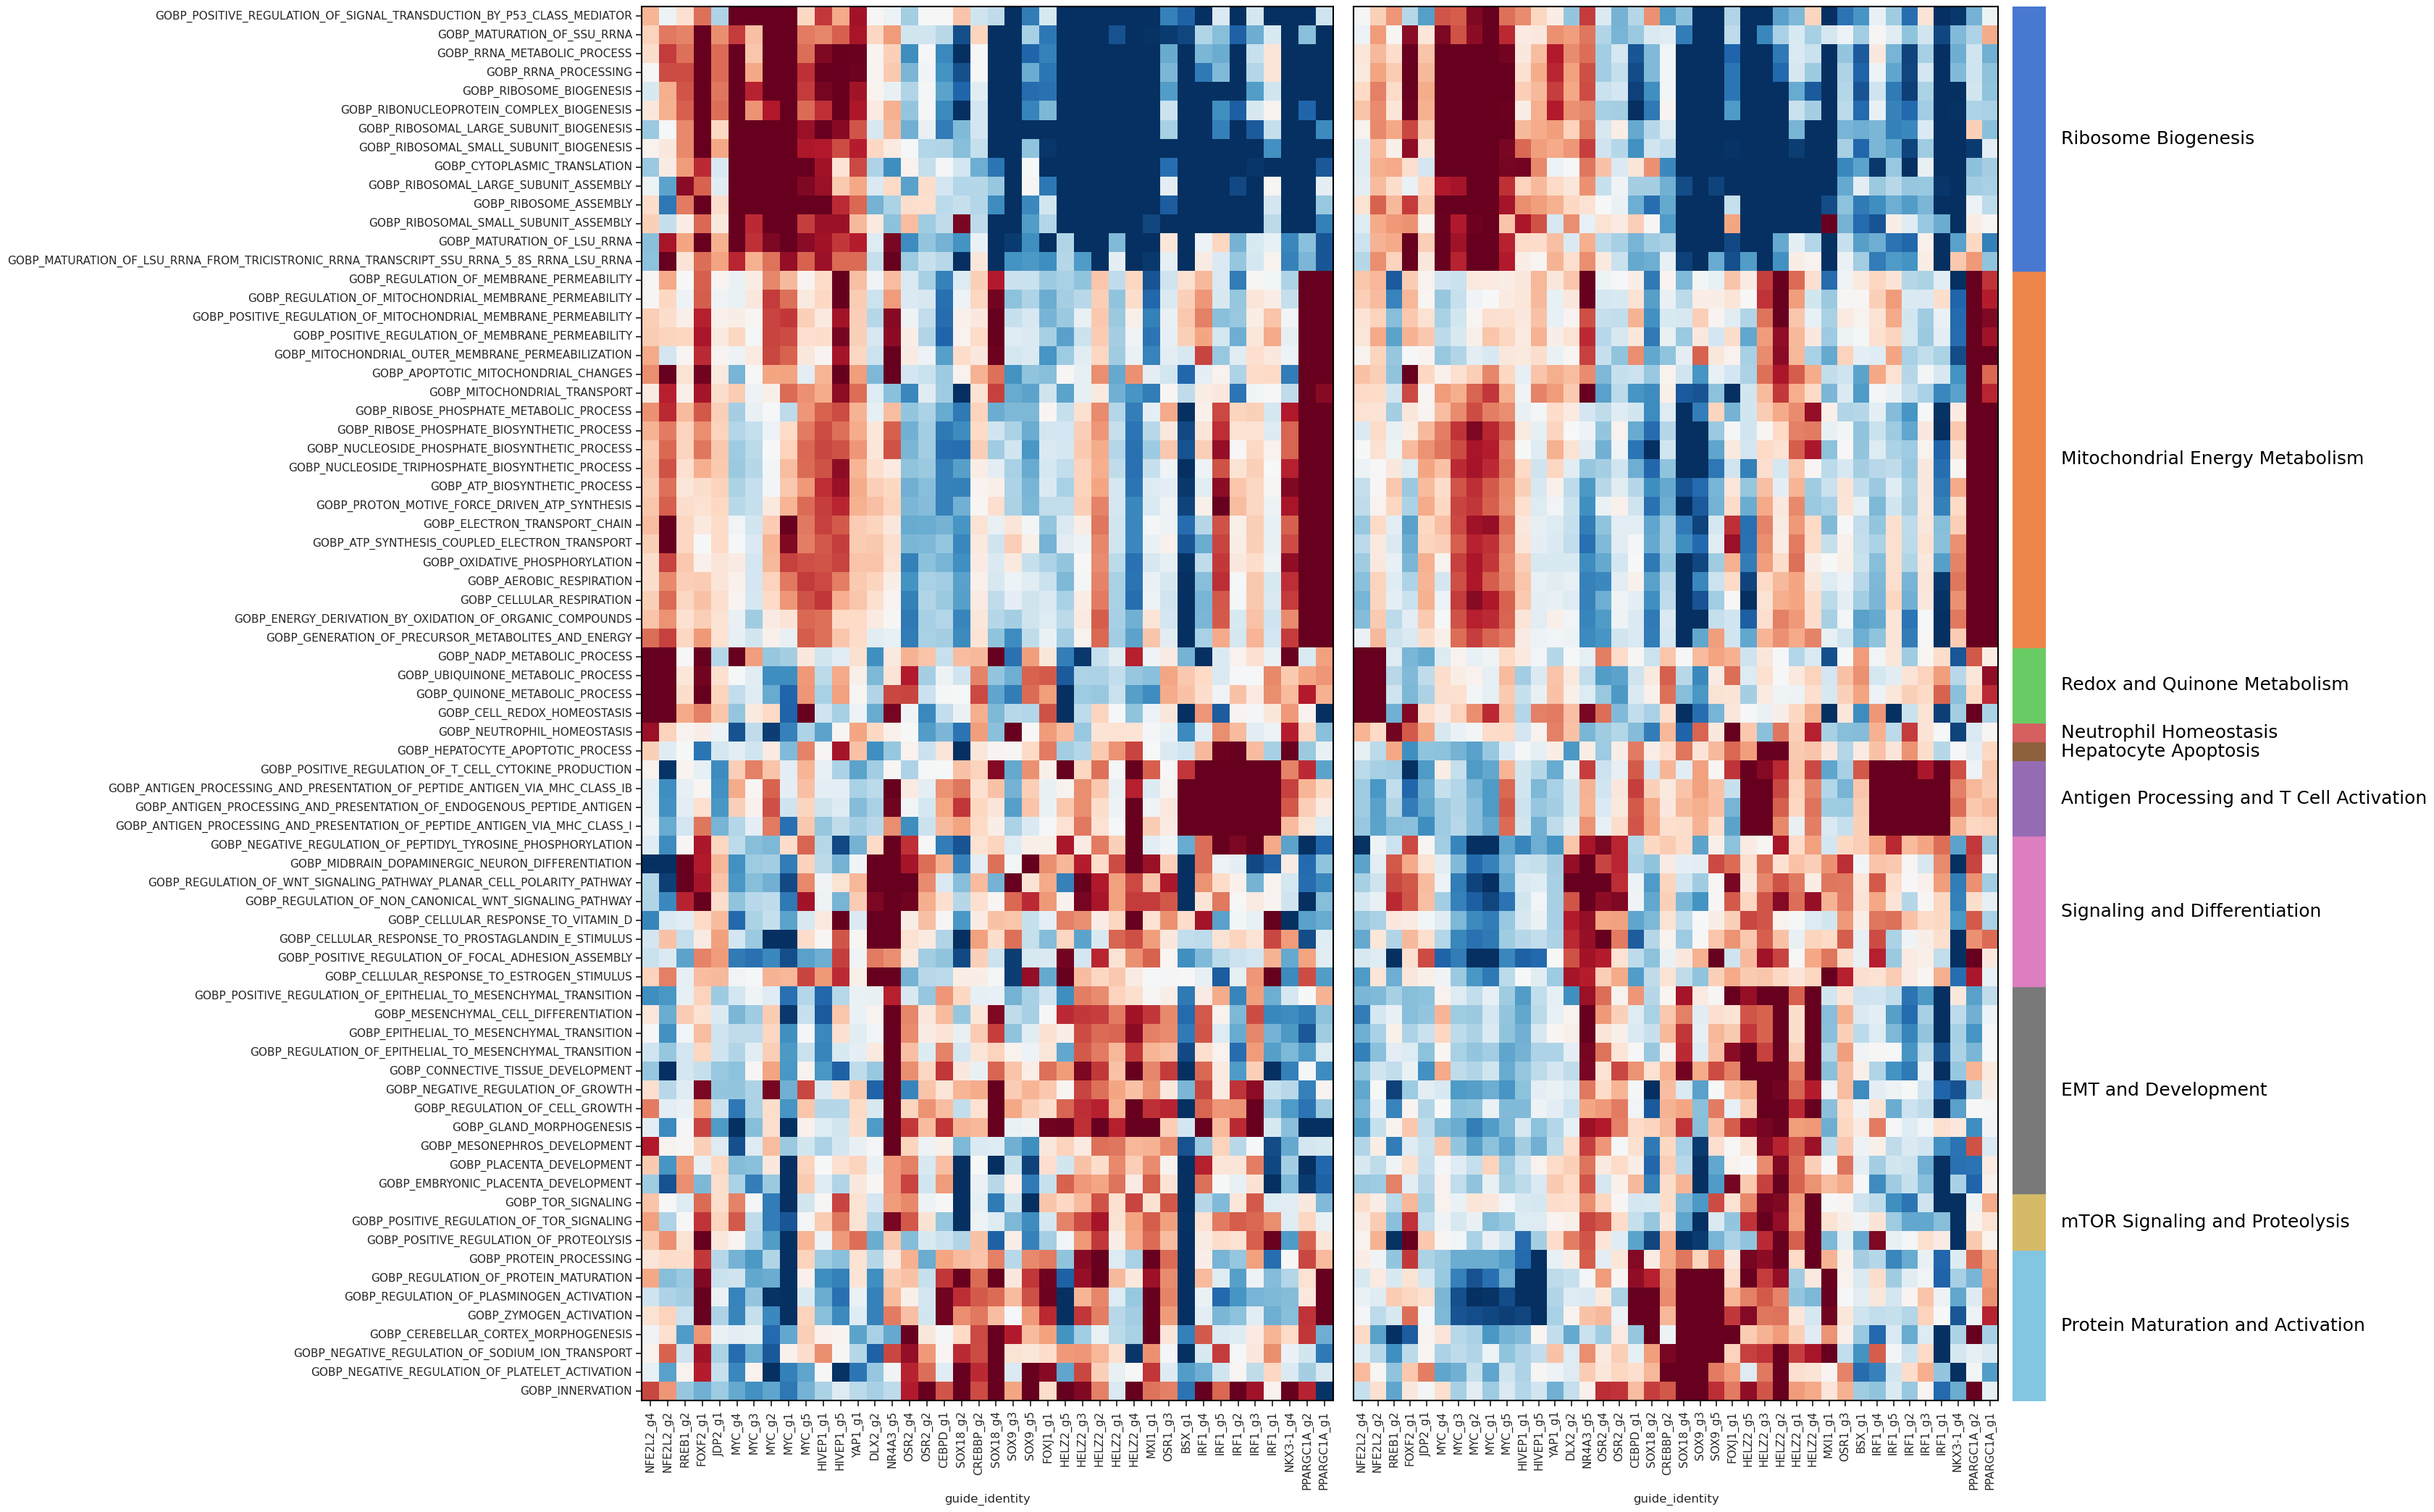

In [76]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(25,25),  gridspec_kw={'wspace': 0.03})

sns.heatmap(select1.loc[:,(abs(select1).quantile(0.9) > 3) & (abs(select2).quantile(0.9) > 3)],
            vmax=8, vmin=-8, cbar=False, cmap="RdBu_r", ax=ax[0])
sns.heatmap(select2.loc[:,(abs(select1).quantile(0.9) > 3) & (abs(select2).quantile(0.9) > 3)],
            vmax=8, vmin=-8, cbar=False, cmap="RdBu_r", ax=ax[1])

ax[1].set_yticks([])
#ax[0].tick_params(axis='both', which='both', length=0)

for a in ax:
        for spine in a.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)
            spine.set_color('black')

cluster_palette = sns.color_palette("muted", n_colors=10)
row_cluster_colors = [cluster_palette[x - 1] for x in reordered_clusters]

def add_row_cluster_colorbar(ax, row_cluster_colors, reordered_clusters, cluster_names):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)  # Add space for the color bar on the right
    # Reverse the colors to match the heatmap's top-to-bottom orientation
    row_cluster_colors = row_cluster_colors[::-1]
    reordered_clusters = reordered_clusters[::-1]
    # Create a vertical color bar
    for i, color in enumerate(row_cluster_colors):
        cax.fill_between([0, 1], i, i + 1, color=color)  # Fill each row with the cluster color
    cax.set_xlim(0, 1)
    cax.set_ylim(0, len(row_cluster_colors))
    cax.set_xticks([])  # Remove x-ticks
    cax.set_yticks([])  # Remove y-ticks
    cax.set_frame_on(False)  # Remove the frame around the color bar

    # Add cluster annotations
    cluster_boundaries = np.where(np.diff(reordered_clusters) != 0)[0] + 1
    cluster_boundaries = np.concatenate([[0], cluster_boundaries, [len(reordered_clusters)]])
    for i in range(len(cluster_boundaries) - 1):
        cluster_start = cluster_boundaries[i]
        cluster_end = cluster_boundaries[i + 1]
        cluster_center = (cluster_start + cluster_end) / 2
        cluster_label = cluster_names[reordered_clusters[cluster_start] - 1]  # Use custom names
        cax.text(1.5, cluster_center, cluster_label, va='center', ha='left', fontsize=18, color='black')
        #wrapped_label = "\n".join(wrap(cluster_label, width=23))  # Adjust width as needed
        #cax.text(1.5, cluster_center, wrapped_label, va='center', ha='left', fontsize=13, color='black')
        
# Add color bars to both subplots
add_row_cluster_colorbar(ax[1], row_cluster_colors, reordered_clusters, cluster_names)
plt.show()
#fig.savefig('20250212_heatmap_horizontal.pdf', bbox_inches='tight')

In [77]:
expressed_both = np.intersect1d(expr_high_fibro, expr_high_rpe1)

In [78]:
common_pops = dict()

In [79]:
common_pops['fibro'] = mean_pops['fibro'][common_pert, expressed_both]
common_pops['rpe1'] = mean_pops['rpe1'][common_pert, expressed_both]

In [80]:
fibro_expr_znorm = pd.DataFrame(
    (common_pops['fibro'].X - mean_pops['fibro'][mean_pops['fibro'].obs.query("control").index, expressed_both].X.mean(axis=0)) \
/ (mean_pops['fibro'][mean_pops['fibro'].obs.query("control").index, expressed_both].X.std(axis=0) ),
    index=common_pert, columns=expressed_both)
rpe1_expr_znorm = pd.DataFrame(
    (common_pops['rpe1'].X - mean_pops['rpe1'][mean_pops['rpe1'].obs.query("control").index, expressed_both].X.mean(axis=0)) \
/ (mean_pops['rpe1'][mean_pops['rpe1'].obs.query("control").index, expressed_both].X.std(axis=0)),
    index=common_pert, columns=expressed_both)

In [81]:
corr_df = filtered_fibro_df.corrwith(filtered_rpe1_df).to_frame("guide_corr (GO term)").merge(
    fibro_expr_znorm.T.loc[expressed_both].corrwith(rpe1_expr_znorm.T.loc[expressed_both]).to_frame("guide_corr (gene expression)"),
    left_index=True, right_index=True)

In [82]:
expr_high = corr_df.loc[top_common_pert]['guide_corr (gene expression)'].quantile(0.8)
GO_high = corr_df.loc[top_common_pert]['guide_corr (GO term)'].quantile(0.8)

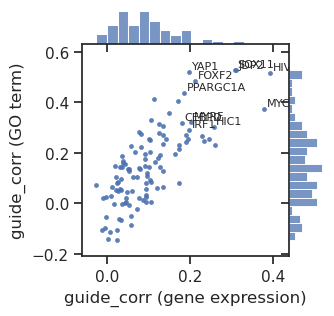

In [83]:
sns.set(style="ticks")
g = sns.jointplot(corr_df.loc[top_common_pert], marginal_kws=dict(bins=20), height=3.5, ratio=6, space=0, 
                   xlim=(-0.06, 0.44), ylim=(-0.21, 0.63), joint_kws=dict(linewidth=0, s=12, alpha=0.9),
                  x="guide_corr (gene expression)", y="guide_corr (GO term)")

for i, point in corr_df.loc[top_common_pert].iterrows():
    if point['guide_corr (gene expression)'] > expr_high and point['guide_corr (GO term)'] > GO_high:
        g.ax_joint.annotate(i.split("_")[0], (point['guide_corr (gene expression)'], point['guide_corr (GO term)']),
                            xytext=(2, 2), textcoords='offset points', fontsize=8)
#g.ax_joint.plot([-0, 0.4], [-0, 0.4], linestyle='--', color='gray', linewidth=1)
g.fig.subplots_adjust(top=0.9)
#g.savefig('20250212_top_guide_correlations_expr_GO.pdf')

In [84]:
corr_df["top"] = corr_df.index.isin(top_common_pert)

In [ ]:
#corr_df.to_csv("correlation_coefficients.csv")